In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
import datetime
from random import sample 

%load_ext tensorboard

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

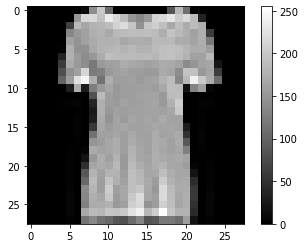

In [5]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

In [6]:
train_images[10].shape

(28, 28)

In [7]:
train_labels[10]

0

## Labels

In [8]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

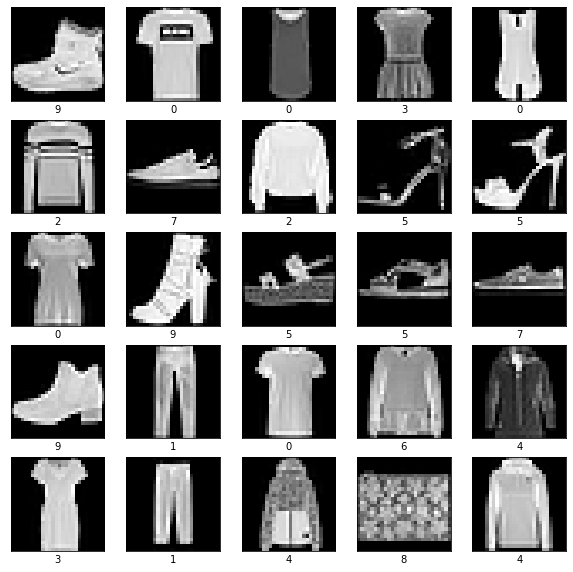

In [9]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

### Proceso de Data Engeenering
Preprocesamiento y preparación de los datos.

In [10]:
#definimos el diccionario para identificar cada una de las labels con su código
diccionario_labels= {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                     6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

diccionario_labels

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

Aplicamos One hot encoding para convertir cada categoría en columna y asignarle valores de 1 o 0 para después poderlas operar como regresión logistica binaria.  
**Se decidió trabajar con las 10 clases disponibles**

In [11]:
#Aplicamos one hot encoding al set de entrenamiento

print("Tamaño se de entrenamiento antes de aplicar One hot Enconding:", train_labels.shape)
ohe_train = OneHotEncoder(categories='auto')
ohe_train.fit(train_labels.reshape(-1, 1))
ohe_labels_train = ohe_train.transform(train_labels.reshape(-1,1)).toarray()
print("Tamaño se de entrenamiento después de aplicar One hot Enconding:", ohe_labels_train.shape)

#Aplicamos one hot encoding al set de validacióm
print("Tamaño se de validación antes de aplicar One hot Enconding:", test_labels.shape)
ohe_test = OneHotEncoder(categories='auto')
ohe_test.fit(test_labels.reshape(-1, 1))
ohe_labels_test = ohe_test.transform(test_labels.reshape(-1,1)).toarray()
print("Tamaño se de validación después de aplicar One hot Enconding:", ohe_labels_test.shape)

Tamaño se de entrenamiento antes de aplicar One hot Enconding: (60000,)
Tamaño se de entrenamiento después de aplicar One hot Enconding: (60000, 10)
Tamaño se de validación antes de aplicar One hot Enconding: (10000,)
Tamaño se de validación después de aplicar One hot Enconding: (10000, 10)


Se realizará una función de pre-procesamiento de los datos para convertir los datos en vectores de fila para posterior uso, tanto los datos crudos, como transformaciones para normalización y escalado de los mismos.

In [12]:
def preprocesar_datos(tensor_imagenes, tipo):
    # Transformamos los datos en un tensor de dos dimensiones
    tensor_transformado = tensor_imagenes.reshape(-1, 28 * 28)
    # Transformamos los datos de acuerdo a un tipo, en donde 1=normalizar, 2=escalar, cualquier otro número=datos crudos
    if tipo == 1:
        tensor_transformado = normalize(tensor_transformado, norm = "max", axis = 1)
        print("Datos Normalizados")
    elif tipo == 2:
        tensor_transformado = scale(tensor_transformado)
        print("Datos Escalados")
    else:
        print("Datos crudos")
        
    #Agregamos la columna de ceros para el sesgo
    tensor_transformado = np.insert(tensor_transformado, 0, np.ones(len(tensor_transformado)), axis=1).astype(np.float32)
    print(tensor_transformado.shape)
    return tensor_transformado

In [13]:
#Utilizamos la función definida anteriormente para realizar el preprocesamiento a los set de entrenamiento y validación
#para datos crudos
x_train = preprocesar_datos(train_images, 0)
x_test = preprocesar_datos(test_images, 0)

#para normalización
x_train_normalizado = preprocesar_datos(train_images, 1)
x_test_normalizado = preprocesar_datos(test_images, 1)

#para escalado
x_train_escalado = preprocesar_datos(train_images, 2)
x_test_escalado = preprocesar_datos(test_images, 2)

Datos crudos
(60000, 785)
Datos crudos
(10000, 785)
Datos Normalizados
(60000, 785)
Datos Normalizados
(10000, 785)
Datos Escalados
(60000, 785)
Datos Escalados
(10000, 785)


### Modelo de Regresión Logistica

In [14]:
#definimos una clase para el modelo de la regresión logística
class regresion_logistica:
    def __init__(self, x, labels):
        #un parametro para cada x de cada clase
        self.parametros = tf.get_variable("parametros", dtype = tf.float32, shape = [x_train.shape[1], labels.shape[1]], initializer = tf.zeros_initializer())
        
    #Calcular los logits
    def c_logits(self, x):
        return tf.matmul(x, self.parametros, name="logits")
    
    #Calculamos la prediccion de probabilidad para cada posible resultado mediante softmax
    def probabilidades_softmax(self, x):
        return tf.nn.softmax(self.c_logits(x))
    
    def c_accuracy(self, p_probabilidades, labels):
        accuracy = tf.equal(tf.argmax(p_probabilidades,1), tf.argmax(labels,1))
        accuracy = tf.dtypes.cast(accuracy, tf.int32)
        #para calcular el acurracy = predicciones correctas del modelo/total predicciones
        accuracy = tf.divide(tf.reduce_sum(accuracy), tf.shape(labels)[0])
        return accuracy
    
    #Calculo del error o costo mediante la entropía cruzada
    def c_error(self, x, y):
        entropia_cruzada = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = self.c_logits(x)))
        return entropia_cruzada
            
    def actualizar_gd(self, x_train, labels_train, learning_rate):
        
        with tf.name_scope("funcion_costo"):
            #Se calcula el costo o error de los datos de entrenamiento
            train_error = self.c_error(x_train, labels_train)
            train_error_summary = tf.summary.scalar("error_entrenamiento", train_error)
        
        with tf.name_scope("softmax"):
            with tf.name_scope("logits"):
                predicciones_train = self.probabilidades_softmax(x_train)
        
        with tf.name_scope("accuracy"):
            train_accuracy = self.c_accuracy(predicciones_train, labels_train)
            train_accuracy_summary = tf.summary.scalar("acurracy_entrenamiento", train_accuracy)
            
        #actualización de parámetros por medio de gradient descent
        gradiente = tf.gradients(train_error, [self.parametros])
        param_actualizados = tf.assign(self.parametros, self.parametros - learning_rate * gradiente[0])
        return param_actualizados, train_error, train_accuracy, train_error_summary, train_accuracy_summary

In [15]:
#Definición de la función para entrenar nuestro modelo
def entrenamiento_rlog(x_train, labels_train, learning_rate, epochs, error_cada):
    # cadena para los datos del experimento
    string = './logs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(learning_rate)+ "_epochs="+str(epochs)
    
    #para entrenamiento con gradient descent se utilizarán mini batch de tamaño 32
    tamaño_mbatch = 32
    total_iteraciones = int((labels_train.shape[0] / tamaño_mbatch) * epochs)
    
    g = tf.Graph()
    with g.as_default():
        
        modelo = regresion_logistica(x_train, ohe_labels_train)
        # Definicion de placeholders para entradas de data a grafo
        with tf.name_scope("x_entrenamiento"):
            tensor_x_train = tf.placeholder(tf.float32, [None,x_train.shape[1]], "tensor_x_train")

        with tf.name_scope("labels_entrenamiento"):
            tensor_labels_train = tf.placeholder(tf.float32, [None,labels_train.shape[1]], "tensor_labels_train")

        #Para realizar el entrenamiento
        parametros_actualizados = modelo.actualizar_gd(tensor_x_train, tensor_labels_train, learning_rate)
    
        # Writer para tensorboard
        writer = tf.summary.FileWriter(string, g)
               
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_iteraciones + 1):
                #Definición de mini-batchs de tamaño 32 para entrenamiento
                offset = (i * tamaño_mbatch) % (labels_train.shape[0] - tamaño_mbatch)
                batch_x = x_train[offset:(offset + tamaño_mbatch),]
                batch_labels = labels_train[offset:(offset + tamaño_mbatch),]
                dict_parametros = {tensor_x_train:batch_x, tensor_labels_train:batch_labels}
                
                entrenamiento = session.run(parametros_actualizados, feed_dict = dict_parametros) # Entrenamiento
                #impresión de eror y escritura para tensorboard
                if (i)%error_cada == 0:
                    
                    parametros = session.run(modelo.parametros, feed_dict = dict_parametros)
                    # Agregar datos para poder visualizarlos en tensorboard
                    writer.add_summary(entrenamiento[3], i)
                    writer.add_summary(entrenamiento[4], i)
                    print("No.epoch:", int(i//(labels_train.shape[0] / tamaño_mbatch)+1), ", mini batch:", i, ", error de entrenamiento:", entrenamiento[1], ", accuracy de entrenamiento:", entrenamiento[2])
                    print("_________________________________________________________________________________________________________________________")
            
            return parametros
            writer.close()

### Experimentos y Entrenamiento del Modelo

#### 1. Datos Crudos

In [16]:
#lr = 0.1 epochs = 5
param_entrenados = entrenamiento_rlog(x_train, ohe_labels_train, 0.1, 5, 500)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 27822.604 , accuracy de entrenamiento: 0.625
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 14177.409 , accuracy de entrenamiento: 0.8125
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini 

In [17]:
#lr = 0.01 epochs = 5
param_entrenados = entrenamiento_rlog(x_train, ohe_labels_train, 0.01, 5, 500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 4596.137 , accuracy de entrenamiento: 0.59375
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 2176.56 , accuracy de entrenamiento: 0.75
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 1510.8818 , accuracy de entrenamiento: 0.75
________________________________________________________________________________________________________________

In [21]:
#lr = 0.01 epochs = 10
param_entrenados = entrenamiento_rlog(x_train, ohe_labels_train, 0.01, 10, 2000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 2 , mini batch: 2000 , error de entrenamiento: 1147.3323 , accuracy de entrenamiento: 0.78125
_________________________________________________________________________________________________________________________
No.epoch: 3 , mini batch: 4000 , error de entrenamiento: 3045.419 , accuracy de entrenamiento: 0.59375
_________________________________________________________________________________________________________________________
No.epoch: 4 , mini batch: 6000 , error de entrenamiento: 679.7117 , accuracy de entrenamiento: 0.84375
________________________________________________________________________________________________________

In [22]:
#lr = 0.001 epochs = 5
param_entrenados = entrenamiento_rlog(x_train, ohe_labels_train, 0.001, 5, 500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 296.44653 , accuracy de entrenamiento: 0.65625
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 135.80775 , accuracy de entrenamiento: 0.84375
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 94.9808 , accuracy de entrenamiento: 0.78125
_________________________________________________________________________________________________________

#### 2. Datos Normalizados

In [35]:
#lr = 0.1 epochs = 5
param_entrenados_nor = entrenamiento_rlog(x_train_normalizado, ohe_labels_train, 0.1, 5, 500)

No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 0.8718115 , accuracy de entrenamiento: 0.71875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 0.6415347 , accuracy de entrenamiento: 0.75
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 0.42584682 , accuracy de entrenamiento: 0.8125
_________________________________________________________________________________________________________________________
No.epoch: 2 , mini batch: 2000 , error de entrenamiento: 0.48387003 , accuracy de entrenamiento: 0.78125

In [24]:
#lr = 0.01 epochs = 5
param_entrenados_nor = entrenamiento_rlog(x_train_normalizado, ohe_labels_train, 0.01, 5, 500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 0.95319206 , accuracy de entrenamiento: 0.71875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 0.67575026 , accuracy de entrenamiento: 0.78125
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 0.54987514 , accuracy de entrenamiento: 0.875
______________________________________________________________________________________________________

In [25]:
#lr = 0.01 epochs = 10
param_entrenados_nor = entrenamiento_rlog(x_train_normalizado, ohe_labels_train, 0.01, 10, 2000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 2 , mini batch: 2000 , error de entrenamiento: 0.62151515 , accuracy de entrenamiento: 0.75
_________________________________________________________________________________________________________________________
No.epoch: 3 , mini batch: 4000 , error de entrenamiento: 0.30362272 , accuracy de entrenamiento: 0.96875
_________________________________________________________________________________________________________________________
No.epoch: 4 , mini batch: 6000 , error de entrenamiento: 0.5194468 , accuracy de entrenamiento: 0.84375
_______________________________________________________________________________________________________

In [26]:
#lr = 0.001 epochs = 5
param_entrenados_nor = entrenamiento_rlog(x_train_normalizado, ohe_labels_train, 0.001, 5, 500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 1.6837054 , accuracy de entrenamiento: 0.59375
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 1.2207675 , accuracy de entrenamiento: 0.78125
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 1.0944993 , accuracy de entrenamiento: 0.78125
_______________________________________________________________________________________________________

#### 3. Datos Escalados

In [27]:
#lr = 0.1 epochs = 5
param_entrenados_esc = entrenamiento_rlog(x_train_escalado, ohe_labels_train, 0.1, 5, 500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 1.1434813 , accuracy de entrenamiento: 0.75
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 1.2893945 , accuracy de entrenamiento: 0.78125
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 0.48903513 , accuracy de entrenamiento: 0.8125
__________________________________________________________________________________________________________

In [31]:
#lr = 0.01 epochs = 5
param_entrenados_esc = entrenamiento_rlog(x_train_escalado, ohe_labels_train, 0.01, 5, 500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 0.730439 , accuracy de entrenamiento: 0.8125
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 0.73000443 , accuracy de entrenamiento: 0.78125
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 0.41169292 , accuracy de entrenamiento: 0.875
_________________________________________________________________________________________________________

In [29]:
#lr = 0.01 epochs = 10
param_entrenados_esc = entrenamiento_rlog(x_train_escalado, ohe_labels_train, 0.01, 10, 2000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 2 , mini batch: 2000 , error de entrenamiento: 0.3279084 , accuracy de entrenamiento: 0.875
_________________________________________________________________________________________________________________________
No.epoch: 3 , mini batch: 4000 , error de entrenamiento: 0.21562022 , accuracy de entrenamiento: 0.90625
_________________________________________________________________________________________________________________________
No.epoch: 4 , mini batch: 6000 , error de entrenamiento: 0.4020495 , accuracy de entrenamiento: 0.84375
_______________________________________________________________________________________________________

In [30]:
#lr = 0.001 epochs = 5
param_entrenados_esc = entrenamiento_rlog(x_train_escalado, ohe_labels_train, 0.001, 5, 500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
No.epoch: 1 , mini batch: 0 , error de entrenamiento: 2.3025854 , accuracy de entrenamiento: 0.1875
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 500 , error de entrenamiento: 0.95271057 , accuracy de entrenamiento: 0.75
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1000 , error de entrenamiento: 0.6979104 , accuracy de entrenamiento: 0.78125
_________________________________________________________________________________________________________________________
No.epoch: 1 , mini batch: 1500 , error de entrenamiento: 0.5513859 , accuracy de entrenamiento: 0.84375
_________________________________________________________________________________________________________

#### Selección Modelo:

De acuerdo a los resultados obtenidos en el entrenamiento, podemos observar que los resultados del error y de acurracy son muy buenos tantos para el entrenamiento con datos normalizados como con datos escalados, sin embargo, produce resultados levemente mejores el modelo entrenado con datos escalados, un learning rate de 0.01 y 5 epochs.

#### Tensorboard

In [19]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 18308.

In [20]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4752), started 0:01:05 ago. (Use '!kill 4752' to kill it.)

### Grafo del Modelo

<img src="./Imagenes/grafo_modelo.png">

### Función para Predicciones

Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.

In [32]:
def predecir(tensor_x, num_img, parametros):
    tf.logging.set_verbosity(tf.logging.ERROR)
    tf.reset_default_graph()
    tensor_x = tensor_x[num_img]
    tensor_x = tensor_x.reshape(1, 785)
    prediccion = tf.get_variable("prediccion", dtype = tf.int32, shape = [],initializer = tf.zeros_initializer())
    tensor_x_test = tf.placeholder(tf.float32, [tensor_x.shape[0], tensor_x.shape[1]], "tensor_x_test")
    tensor_parametros = tf.placeholder(tf.float32, [parametros.shape[0], parametros.shape[1]], "tensor_parametros")
    prediccion_softmax = tf.argmax(tf.nn.softmax(tf.matmul(tensor_x_test, tensor_parametros)),1)
    
    with tf.train.MonitoredSession() as session:
                                 
        feed_dict = {tensor_x_test:tensor_x, tensor_parametros: parametros}
        label_predecido = session.run(prediccion_softmax, feed_dict = feed_dict)
        diccionario_labels.get(int(label_predecido))
        plt.imshow(test_images[num_img], cmap = 'gray')
        plt.title(diccionario_labels.get(int(label_predecido)))
        plt.xticks([])
        plt.yticks([])
        plt.show()

Utilizando la función anterior se presentará una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda).

Se realizarán pruebas primero con el modelo que produjo los mejores resultados, el cual fue entrenado con datos escalados.

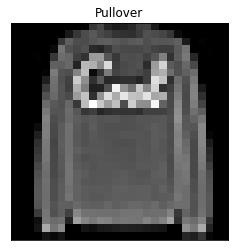

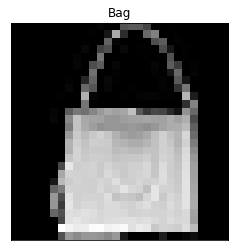

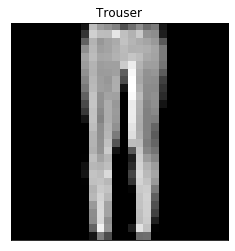

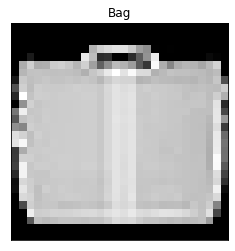

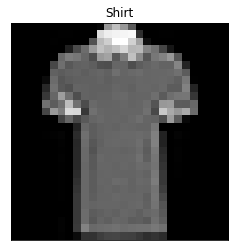

In [34]:
#pruebas con imagenes del set de datos de test para 5 imagenes 
indices = list(np.linspace(0,len(x_test), len(x_test), dtype=np.int32))

#se envían a la función los parametros y los set de datos correspondientes al modelo seleccionado
for i in sample(indices,5):
    predecir(x_test_escalado, i, param_entrenados_esc)

Ahora se probará la función con el segundo mejor modelo, el cual fue el que se entrenó con los datos normalizados

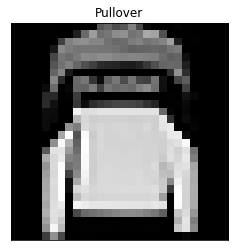

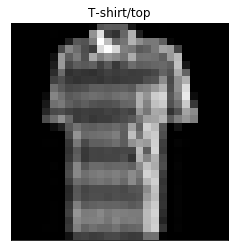

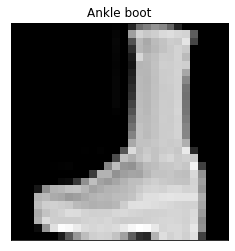

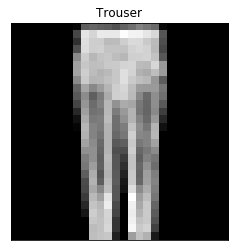

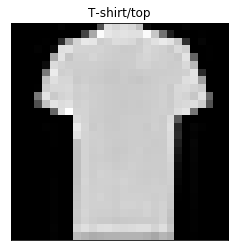

In [38]:
for i in sample(indices,5):
    predecir(x_test_normalizado, i, param_entrenados_nor)

Por último aplicaremos la función al modelo que produjo los peores resultados respecto a los otros dos, el cual fue entrenado con los datos crudos

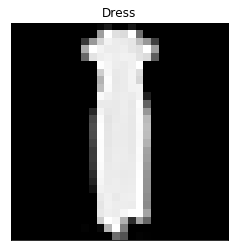

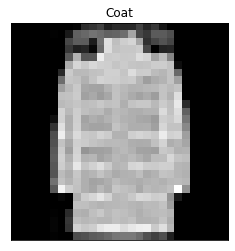

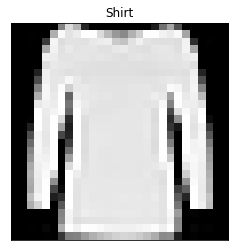

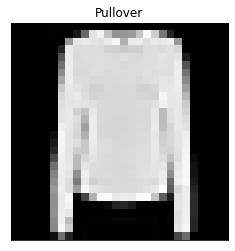

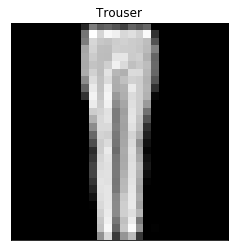

In [42]:
for i in sample(indices,5):
    predecir(x_test, i, param_entrenados)

### Conclusiones

En las siguientes imagenes del entrenamiento realizado, se pueden observar las métricas de los tres experimentos que dieron los mejores resultados para los tres set de datos: datos crudos, datos normalizados y datos escalados.

* **Celeste: entrenamiento con datos crudos con learning rate = 0.001 y 5 epochs**
* **Rosado:  entrenamiento con datos normalizados con learning rate = 0.1 y 5 epochs**
* **Rojo:    entrenamiento con datos crudos con learning rate = 0.01 y 5 epochs**

En terminos generales se puede observar que es más efectivo utilizar datos normalizados y datos escalados para mejorar el rendimiento del modelo de regresión logística, ya que, en cuanto a métricas, tanto el error bajó y aumentó el acurracy.

**Error:**

<img src="./Imagenes/error1.png">
<img src="./Imagenes/error2.png">

**Acurracy:**

<img src="./Imagenes/acurracy1.png">
<img src="./Imagenes/acurracy2.png">

* En terminos generales los datos normalizados y escalados dieron mejores resultados que los datos crudos, lo cual podría ser debido a la estabilidad númerica que proporcionan por ser datos más pequeños que los datos crudos.
* También se puede observar que los tres modelos necesitaron 5 epochs, ya ue se realizaron pruebas con más epochs pero no se lograban mejores resultados, así mismo, para los datos crudos se necesitó un learning rate más pequeño.
* Ya que los modelos con datos escalados y datos normalizados produjeron muy buenos resultados, se decidió seleccionar el modelo con datos escalados, ya que levemente es mejor. Este tuvo un eror de 0.4678 y alcanzó un acurracy de 96%, entrenado con un learning rate= 0.01 y 5 epochs.
* Al realizar varias pruebas con los parámetros resultantes del modelo entrenado con los datos crudos, pude darme cuenta que en algunas ocaciones predecía equivocadamente en imagenes muy borrosas.
